In [3]:
try:
    from google.colab import drive
    NOTEBOOK = 'colab'
except:
    import os    
    if list(os.walk('/kaggle/input')):            
        NOTEBOOK = 'kaggle'
    else:
        NOTEBOOK = 'home'
        
if NOTEBOOK == 'colab':
    drive.mount("/content/gdrive", force_remount=True)

import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# tf.config.set_visible_devices([], 'GPU') 
# tf.executing_eagerly() 

print(NOTEBOOK)




home


In [4]:
if NOTEBOOK == 'colab':
    !pip install -q dm-sonnet
    !pip install -q gdown
    import gdown    
#     url = 'https://drive.google.com/uc?id=1Si-Fz-38xITBOvYOoPTn_xLtOHVwqFQO'
    url = 'https://drive.google.com/uc?id=1rMDDybiyw6bLOdVOL_SY-RoQdocRRNzl'
    output = 'GOLD_XYZ.hdf5'
    gdown.download(url, output, quiet=False)
    !df -h
    !ls -l
    !grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'
    hdf5_path = '/content/'+output
elif NOTEBOOK == 'kaggle':
    !pip install -q dm-sonnet
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            hdf5_path = os.path.join(dirname, filename)
else:          
    hdf5_path = '/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
print(hdf5_path)


/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5


In [5]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import time
import h5py
import sonnet as snt
from tqdm import tqdm

print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))
print("    Numpy  version: {}".format(np.__version__))
from tensorboard import version; print("TensorBoard version: {}".format(version.VERSION))
# tf.config.list_physical_devices('GPU')

TensorFlow version: 2.1.0
    Sonnet version: 2.0.0
    Numpy  version: 1.18.2
TensorBoard version: 2.2.0


In [32]:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

class AlphaDropout(snt.Module):

  def __init__(self, name=None, rate=0.5, noise_shape=None, seed=None, **kwargs):
    super(AlphaDropout, self).__init__(name=name)
    self.rate = rate
    self.noise_shape = noise_shape
    self.seed = seed

  def _get_noise_shape(self, inputs):
    return self.noise_shape if self.noise_shape else inputs.shape

  def __call__(self, inputs, is_training=None):
    if 0. < self.rate < 1.:
      noise_shape = self._get_noise_shape(inputs)

      def dropped_inputs(inputs=inputs, rate=self.rate, seed=self.seed):  # pylint: disable=missing-docstring
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -alpha * scale

        kept_idx = math_ops.greater_equal(
            tf.random.uniform(noise_shape, minval=0, maxval=None, dtype=tf.dtypes.float32, seed=seed, name=None), rate)
        kept_idx = math_ops.cast(kept_idx, dtypes.float32)

        # Get affine transformation params
        a = ((1 - rate) * (1 + rate * alpha_p**2))**-0.5
        b = -a * alpha_p * rate

        # Apply mask
        x = inputs * kept_idx + alpha_p * (1 - kept_idx)

        # Do affine transformation
        return a * x + b
      
        if is_training==True:
            return dropped_inputs(inputs)
        else: 
            return inputs
    return inputs


  

In [45]:
class ConvMaxPool(snt.Module):
    def __init__(self, name=None):
        super(ConvMaxPool, self).__init__(name=name)
        self.conv = snt.Conv1D(output_channels=64, kernel_shape=3, stride=1, rate=1,
                               padding="SAME", with_bias=True,
                               data_format="NWC", name="conv_max_pool"
                               )

    def __call__(self, inputs):
        features = self.conv(inputs)
        outputs = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="SAME", 
                                   data_format='NWC', name="pool") #64×1024
        return outputs

# @tf.function
class CNN(snt.Module):
    def __init__(self, epsilon, name=None):
        super(CNN, self).__init__(name=name)
        self.layers = [
            ConvMaxPool(name="conv"+str(ii))
            for ii in range(6)
        ]
        self.conv_in = snt.Conv1D(output_channels=64, kernel_shape=2, stride=1, rate=1,
                       padding="SAME", with_bias=True,
                       data_format="NWC", name="conv_input"
                       )
        
        self.linear = snt.Linear(output_size=128, with_bias=True, 
                                 w_init=snt.initializers.VarianceScaling(scale = 1.0, mode='fan_in', distribution='truncated_normal', seed=10))
        self.linear1 = snt.Linear(output_size=128, with_bias=True,
                                 w_init=snt.initializers.VarianceScaling(scale = 1.0, mode='fan_in', distribution='truncated_normal', seed=13))
        self.linear2 = snt.Linear(output_size=24, with_bias=True,
                                 w_init=snt.initializers.VarianceScaling(scale = 1.0, mode='fan_in', distribution='truncated_normal', seed=14))                
        
        self.alpha = AlphaDropout(rate=0.1, noise_shape=None, seed=21)
#         self.alpha = snt.Dropout(rate=0.1, noise_shape=None, seed=21, name="DO")

    
    def __call__(self, inputs, is_training=False):
        features = self.conv_in(inputs) #2×1024
        features = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="VALID", 
                                    data_format='NWC', name="pool_input") 
#         print(features)
        for layer in self.layers:
            features = layer(features)    
        features = snt.flatten(features)

        features = self.linear(features)
        features = self.alpha(tf.nn.selu(features), is_training=is_training)
        features = self.linear1(features)
        features = self.alpha(tf.nn.selu(features), is_training=is_training)

        output = self.linear2(features)        
#         output = tf.nn.softmax(features)
        return output


In [46]:
class CNNOptimizer(snt.Module):
    def __init__(self, name, cnn, lr=1e-3, num_epochs=100, decay_lr_start_epoch=10, decay_lr=False):
        super(CNNOptimizer, self).__init__(name=name)
        self.cnn = cnn
        self.init_lr = lr
        self.lr = tf.Variable(lr, trainable=False, name='learning rate', dtype=tf.float32)
        self.cnn_opt = snt.optimizers.Adam(learning_rate=self.lr)#, beta1=0.)
        self.decay_lr_start_epoch = tf.constant(decay_lr_start_epoch, dtype=tf.int32)
        self.decay_lr = tf.constant(decay_lr, dtype=tf.float32)
        self.num_epochs = tf.constant(num_epochs, dtype=tf.int32)

    def _gen_lr_mult(self, epoch):
          # Linear decay to 0.
        decay_epoch = tf.cast(epoch - self.decay_lr_start_epoch, tf.float32)
        if decay_epoch < tf.constant(0, dtype=tf.float32):
            return tf.constant(1., dtype=tf.float32)
        num_decay_epochs = tf.cast(self.num_epochs - self.decay_lr_start_epoch, dtype=tf.float32)
        return (num_decay_epochs - decay_epoch) / num_decay_epochs        
      
    def step(self, batch, labels, epoch, step):
        with tf.GradientTape() as tape:
            logits = self.cnn(batch, is_training=True)    
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
            loss = tf.reduce_mean(loss)
        params = self.cnn.trainable_variables
        grads = tape.gradient(loss, params)                
        lr_mult = self._gen_lr_mult(epoch)
        if self.decay_lr:
            self.lr.assign(self.init_lr * lr_mult)
        self.cnn_opt.apply(grads, params)   
        if NOTEBOOK != 'kaggle':
            with writer.as_default():
                for i,g in enumerate(grads):                
                    tf.summary.histogram(name="Grad_"+params[i].name, data=g, step=step)                
                    tf.summary.histogram(name=params[i].name, data=params[i].value(), step=step)                
        return loss
    




In [25]:
class radioML:
    def __init__(self, file, batch_size, is_training=False):
        self.file = file
        self.batch_size = batch_size
        self.is_training = is_training

    def __call__(self):        
        N_r, N_m, N_db = 4096, 24, 13
        if NOTEBOOK == 'colab':            
            dbs = np.arange(0,32,2)     
            db_range = np.arange(0,0+len(dbs))
        else:                       
            dbs = np.arange(0,32,2)                   
            db_range = np.arange(10,10+len(dbs))
        data_idxs_train = np.array([])
        data_idxs_test = np.array([])
        for i in np.arange(N_m):            
            for j in db_range:
                ids = i*N_r*N_db+j*N_r
                idx = np.arange(ids, ids+N_r)                
                data_idxs_train = np.append(data_idxs_train, idx[np.arange(int(0.8*N_r))])
                data_idxs_test  = np.append(data_idxs_test, idx[np.arange(int(0.8*N_r)+1, N_r)])
        with h5py.File(self.file, 'r') as f:
            while True:
                if self.is_training:
                    idxs = np.random.choice(data_idxs_train, self.batch_size)
                    yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                else:
                    idxs = np.random.choice(data_idxs_test, self.batch_size)
                    yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                

def radioML_map(data_batch, data_label):
#     print(data_batch.shape)
    data_batch = tf.reshape(data_batch, [1024, 2])
    data_label = tf.reshape(data_label, [24])
#     mean = tf.math.reduce_mean(data_batch)
#     std = tf.math.reduce_std(data_batch)
#     data_batch = (data_batch - mean)/std
#     print(std, mean)
#     print(type(std))
    return (data_batch, data_label)

<dtype: 'int32'>


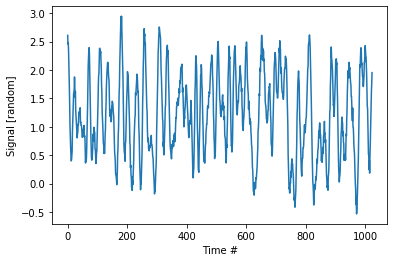

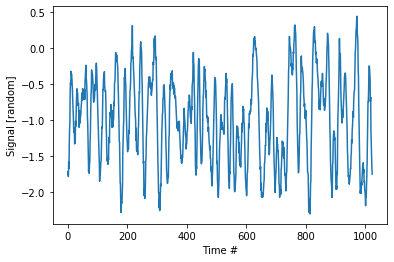

In [47]:
radio_plot = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_plot = radio_plot.take(1)
radio_plot = radio_plot.map(radioML_map)
for (batch, labels) in radio_plot:    
    print(labels.dtype)
    fig1 = plt.figure()
    plt.plot(batch[:,0])
    plt.xlabel('Time #')
    plt.ylabel('Signal [random]')
    fig2 = plt.figure()
    plt.plot(batch[:,1])
    plt.xlabel('Time #')
    plt.ylabel('Signal [random]')
    plt.show()

In [ ]:
# building tensorflow graph

# from datetime import datetime as dt
# # Clear any logs from previous runs
# !rm -rf ./logs/

# stamp = dt.now().strftime("%Y%m%d-%H%M%S")
# logdir = 'logs/func/%s' % stamp
# writer = tf.summary.create_file_writer(logdir)

# radio_model = CNN(epsilon=1e-8, name="CNN")
# radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
#                 output_types=(tf.float32, tf.float32),
#                 output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]
# radio_data_test = radio_data_test.take(1)
# radio_data_test = radio_data_test.map(radioML_map)
# radio_data_test = radio_data_test.batch(1)

# for i,(batch, labels) in enumerate(radio_data_test):
#     tf.summary.trace_on(graph=True, profiler=True)    
#     preds = radio_model(batch)
#     with writer.as_default():
#         tf.summary.trace_export(
#             name='tf2_graph',
#             step=0,
#             profiler_outdir=logdir)
# %reload_ext tensorboard
# %tensorboard --logdir logs/func     

In [51]:
if NOTEBOOK != 'kaggle':
    # %load_ext tensorboard
    # import os
    from datetime import datetime as dt
    # Clear any logs from previous runs
    !rm -rf ./logs/
    log_dir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
    writer = tf.summary.create_file_writer(log_dir)


    %reload_ext tensorboard
#     %tensorboard --logdir logs/func     
    # writer.set_as_default()
    %tensorboard --logdir logs

In [53]:

batch_size = 64
# num_batches = int(1572864/batch_size)
num_batches = int(4096/batch_size)

num_epochs = 20

radio_model = CNN(epsilon=1e-8, name="CNN")
radio_opt = CNNOptimizer(name="Optimizer", cnn=radio_model, lr=0.001, \
                         num_epochs=num_epochs, decay_lr_start_epoch=10, decay_lr=True)

t = tqdm(range(num_batches * num_epochs),
               unit='sig', unit_scale=batch_size, position=0)


radio_data_train = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, True), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

loss = 0

radio_data_train = radio_data_train.take(batch_size*num_batches)
radio_data_train = radio_data_train.map(radioML_map)
radio_data_train = radio_data_train.shuffle(buffer_size=batch_size*num_batches)
radio_data_train = radio_data_train.batch(batch_size)
radio_data_train = radio_data_train.prefetch(tf.data.experimental.AUTOTUNE)
radio_data_train = radio_data_train.repeat(num_epochs)
radio_data_train = radio_data_train.cache()

test = radio_data_test.take(1024)
test = test.map(radioML_map)
test = test.batch(batch_size)


# step = tf.function(radio_opt.step)
print_every = int(num_batches/2)

start_time = time.perf_counter()
for step_num,(batch, labels) in enumerate(radio_data_train):      
    epoch = tf.constant(1+int(step_num / (num_batches)))
    loss = radio_opt.step(batch, labels, epoch, step_num)
    
    if NOTEBOOK != 'kaggle':
        with writer.as_default():
            tf.summary.scalar('training loss', loss, step=step_num)            
        
    t.update(1)    
    if step_num % print_every == 0:                
        t.write('Current epoch = {}/{} (lr_mult = {:0.09f}, loss = {}) done.'.format(
            epoch.numpy(), num_epochs, radio_opt.lr.numpy(), loss.numpy()))  
        
    if step_num % num_batches == 0: 
        accuracy, total, correct = tf.constant(0), tf.constant(0), tf.constant(0)
        for (batch, labels) in test:            
            logits = tf.nn.softmax(radio_opt.cnn(batch, is_training=False))
            preds = tf.argmax(logits, axis=1, output_type=tf.int32)  
            labels = tf.argmax(labels, axis=1, output_type=tf.int32)
            correct += tf.math.count_nonzero(tf.equal(preds, labels), dtype=tf.int32)
            total += tf.shape(labels)[0]            
        accuracy = (correct / tf.cast(total, tf.int32)) * 100. 
        if NOTEBOOK != 'kaggle':
            with writer.as_default():
                tf.summary.scalar('Accuracy', accuracy, step=epoch.numpy())   
                tf.summary.scalar('learning rate', radio_opt.lr, step=step_num)    
        t.write('Epoch = {}/{} (lr_mult = {:0.09f}, loss = {:0.02f}, accuracy = {:0.02f}, incorrect = {} done.'.format(
            epoch.numpy(), num_epochs, radio_opt.lr.numpy(), loss.numpy(), accuracy, total - correct))  
                 
print("Execution time:", time.perf_counter() - start_time)   
t.close()
   

  0%|          | 0/81920 [09:07<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 1/20 (lr_mult = 0.001000000, loss = 3.254000186920166) done.


  0%|          | 0/81920 [09:35<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 1/20 (lr_mult = 0.001000000, loss = 3.25, accuracy = 6.84, incorrect = 954 done.


  0%|          | 0/81920 [09:45<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 1/20 (lr_mult = 0.001000000, loss = 2.4381723403930664) done.


  0%|          | 0/81920 [10:41<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 2/20 (lr_mult = 0.001000000, loss = 2.1890549659729004) done.


  0%|          | 0/81920 [11:03<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 2/20 (lr_mult = 0.001000000, loss = 2.19, accuracy = 14.84, incorrect = 872 done.


  0%|          | 0/81920 [11:13<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 2/20 (lr_mult = 0.001000000, loss = 2.2902097702026367) done.


  0%|          | 0/81920 [12:12<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 3/20 (lr_mult = 0.001000000, loss = 2.089132308959961) done.


  0%|          | 0/81920 [12:27<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 3/20 (lr_mult = 0.001000000, loss = 2.09, accuracy = 14.55, incorrect = 875 done.


  0%|          | 0/81920 [12:36<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 3/20 (lr_mult = 0.001000000, loss = 2.0538809299468994) done.


  0%|          | 0/81920 [13:39<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 4/20 (lr_mult = 0.001000000, loss = 2.093994617462158) done.


  0%|          | 0/81920 [13:52<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 4/20 (lr_mult = 0.001000000, loss = 2.09, accuracy = 19.53, incorrect = 824 done.


  0%|          | 0/81920 [14:02<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 4/20 (lr_mult = 0.001000000, loss = 2.194552421569824) done.


  0%|          | 0/81920 [15:03<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 5/20 (lr_mult = 0.001000000, loss = 2.0135185718536377) done.


  0%|          | 0/81920 [15:16<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 5/20 (lr_mult = 0.001000000, loss = 2.01, accuracy = 20.12, incorrect = 818 done.


  0%|          | 0/81920 [15:25<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 5/20 (lr_mult = 0.001000000, loss = 2.066833257675171) done.


  0%|          | 0/81920 [16:29<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 6/20 (lr_mult = 0.001000000, loss = 2.092653751373291) done.


  0%|          | 0/81920 [16:41<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 6/20 (lr_mult = 0.001000000, loss = 2.09, accuracy = 21.39, incorrect = 805 done.


  0%|          | 0/81920 [16:50<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 6/20 (lr_mult = 0.001000000, loss = 2.0932154655456543) done.


  0%|          | 0/81920 [17:50<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 7/20 (lr_mult = 0.001000000, loss = 1.886879324913025) done.


  0%|          | 0/81920 [18:07<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 7/20 (lr_mult = 0.001000000, loss = 1.89, accuracy = 21.29, incorrect = 806 done.


  0%|          | 0/81920 [18:16<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 7/20 (lr_mult = 0.001000000, loss = 2.0532217025756836) done.


  0%|          | 0/81920 [19:15<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 8/20 (lr_mult = 0.001000000, loss = 2.08137845993042) done.


  0%|          | 0/81920 [19:26<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 8/20 (lr_mult = 0.001000000, loss = 2.08, accuracy = 22.46, incorrect = 794 done.


  0%|          | 0/81920 [19:36<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 8/20 (lr_mult = 0.001000000, loss = 2.0479912757873535) done.


  0%|          | 0/81920 [20:38<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 9/20 (lr_mult = 0.001000000, loss = 2.020162582397461) done.


  0%|          | 0/81920 [20:52<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 9/20 (lr_mult = 0.001000000, loss = 2.02, accuracy = 21.09, incorrect = 808 done.


  0%|          | 0/81920 [21:02<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 9/20 (lr_mult = 0.001000000, loss = 2.052412748336792) done.


  0%|          | 0/81920 [22:03<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 10/20 (lr_mult = 0.001000000, loss = 1.7996009588241577) done.


  0%|          | 0/81920 [22:17<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 10/20 (lr_mult = 0.001000000, loss = 1.80, accuracy = 23.05, incorrect = 788 done.


  0%|          | 0/81920 [22:26<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 10/20 (lr_mult = 0.001000000, loss = 2.024196147918701) done.


  0%|          | 0/81920 [23:33<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 11/20 (lr_mult = 0.000900000, loss = 1.9665948152542114) done.


  0%|          | 0/81920 [23:45<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 11/20 (lr_mult = 0.000900000, loss = 1.97, accuracy = 19.92, incorrect = 820 done.


  0%|          | 0/81920 [23:54<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 11/20 (lr_mult = 0.000900000, loss = 1.9188499450683594) done.


  0%|          | 0/81920 [25:03<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 12/20 (lr_mult = 0.000800000, loss = 2.013108730316162) done.


  0%|          | 0/81920 [25:17<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 12/20 (lr_mult = 0.000800000, loss = 2.01, accuracy = 19.92, incorrect = 820 done.


  0%|          | 0/81920 [25:27<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 12/20 (lr_mult = 0.000800000, loss = 1.8626848459243774) done.


  0%|          | 0/81920 [26:32<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 13/20 (lr_mult = 0.000700000, loss = 1.926251769065857) done.


  0%|          | 0/81920 [26:49<?, ?sig/s], 56.30sig/s]2sig/s]

Epoch = 13/20 (lr_mult = 0.000700000, loss = 1.93, accuracy = 21.39, incorrect = 805 done.


  0%|          | 0/81920 [26:59<?, ?sig/s], 56.30sig/s]2sig/s]

Current epoch = 13/20 (lr_mult = 0.000700000, loss = 2.0558207035064697) done.


  0%|          | 0/81920 [28:03<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 14/20 (lr_mult = 0.000600000, loss = 2.0721988677978516) done.


  0%|          | 0/81920 [28:17<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 14/20 (lr_mult = 0.000600000, loss = 2.07, accuracy = 23.93, incorrect = 779 done.


  0%|          | 0/81920 [28:26<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 14/20 (lr_mult = 0.000600000, loss = 1.987619161605835) done.


  0%|          | 0/81920 [29:31<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 15/20 (lr_mult = 0.000500000, loss = 2.0007917881011963) done.


  0%|          | 0/81920 [29:46<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 15/20 (lr_mult = 0.000500000, loss = 2.00, accuracy = 27.44, incorrect = 743 done.


  0%|          | 0/81920 [29:55<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 15/20 (lr_mult = 0.000500000, loss = 1.9080508947372437) done.


  0%|          | 0/81920 [30:53<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 16/20 (lr_mult = 0.000400000, loss = 1.8984897136688232) done.


  0%|          | 0/81920 [31:05<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 16/20 (lr_mult = 0.000400000, loss = 1.90, accuracy = 25.00, incorrect = 768 done.


  0%|          | 0/81920 [31:14<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 16/20 (lr_mult = 0.000400000, loss = 1.7692502737045288) done.


  0%|          | 0/81920 [32:12<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 17/20 (lr_mult = 0.000300000, loss = 2.013735771179199) done.


  0%|          | 0/81920 [32:25<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 17/20 (lr_mult = 0.000300000, loss = 2.01, accuracy = 25.29, incorrect = 765 done.


  0%|          | 0/81920 [32:34<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 17/20 (lr_mult = 0.000300000, loss = 1.9139249324798584) done.


  0%|          | 0/81920 [33:41<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 18/20 (lr_mult = 0.000200000, loss = 1.8887553215026855) done.


  0%|          | 0/81920 [33:54<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 18/20 (lr_mult = 0.000200000, loss = 1.89, accuracy = 26.27, incorrect = 755 done.


  0%|          | 0/81920 [34:03<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 18/20 (lr_mult = 0.000200000, loss = 1.8612724542617798) done.


  0%|          | 0/81920 [35:14<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 19/20 (lr_mult = 0.000100000, loss = 1.8229283094406128) done.


  0%|          | 0/81920 [35:27<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 19/20 (lr_mult = 0.000100000, loss = 1.82, accuracy = 28.52, incorrect = 732 done.


  0%|          | 0/81920 [35:35<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 19/20 (lr_mult = 0.000100000, loss = 1.79054594039917) done.


  0%|          | 0/81920 [36:33<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 20/20 (lr_mult = 0.000000000, loss = 1.7569247484207153) done.


  0%|          | 0/81920 [36:46<?, ?sig/s]49, 56.30sig/s]ig/s]

Epoch = 20/20 (lr_mult = 0.000000000, loss = 1.76, accuracy = 31.15, incorrect = 705 done.


  0%|          | 0/81920 [36:55<?, ?sig/s]49, 56.30sig/s]ig/s]

Current epoch = 20/20 (lr_mult = 0.000000000, loss = 1.914027214050293) done.


100%|██████████| 81920/81920 [28:51<00:00, 47.31sig/s] 

Execution time: 1731.5753917750008


In [ ]:
radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]
test = radio_data_test.take(1024)
test = test.map(radioML_map)
test = test.batch(batch_size)
for (batch, labels) in test:
    preds = tf.argmax(radio_opt.cnn(batch), output_type=tf.int32)
    correct += tf.math.count_nonzero(tf.equal(preds, labels), dtype=tf.int32)
    total += tf.shape(labels)[0]
accuracy = (correct / tf.cast(total, tf.int32)) * 100.   
print("Final accuracy:", accuracy)

In [ ]:
tf.math.is_nan(loss_history)
loss_history = loss_history
fig2 = plt.figure()
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()
loss_history

In [16]:
print(snt.format_variables(radio_model.variables))

| Variable                  | Spec          | Trainable   | Device   |
|---------------------------+---------------+-------------+----------|
| CNN/conv0/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv0/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv1/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv1/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv2/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv2/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv3/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv3/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv4/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv4/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv5/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv5/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/